In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/playground-series-s5e2/sample_submission.csv
/kaggle/input/playground-series-s5e2/train.csv
/kaggle/input/playground-series-s5e2/test.csv
/kaggle/input/playground-series-s5e2/training_extra.csv


# **Reading the input files (dataset)**

In [6]:
#train = pd.read_csv('../input/playground-series-s5e2/train.csv')
#print('The dimension of the train dataset is:', train.shape)
#print(train.head())
train = pd.read_csv('../input/playground-series-s5e2/training_extra.csv')
print('The dimension of the extra train dataset is:', train.shape)
print(train.head())
test = pd.read_csv('../input/playground-series-s5e2/test.csv')
print('The dimension of the test dataset is:', test.shape)
print(test.head())


The dimension of the extra train dataset is: (3694318, 11)
       id         Brand   Material   Size  Compartments Laptop Compartment  \
0  500000  Under Armour     Canvas  Small          10.0                Yes   
1  500001          Puma  Polyester  Small           4.0                 No   
2  500002      Jansport  Polyester  Small           8.0                Yes   
3  500003          Nike      Nylon  Large           7.0                 No   
4  500004          Nike    Leather  Large           9.0                 No   

  Waterproof      Style  Color  Weight Capacity (kg)      Price  
0        Yes       Tote   Blue             23.882052  114.11068  
1        Yes   Backpack  Green             11.869095  129.74972  
2        Yes       Tote    Red              8.092302   21.37370  
3         No  Messenger   Pink              7.719581   48.09209  
4        Yes       Tote  Green             22.741826   77.32461  
The dimension of the test dataset is: (200000, 10)
       id   Brand Materia

# **Checking if missing datas**

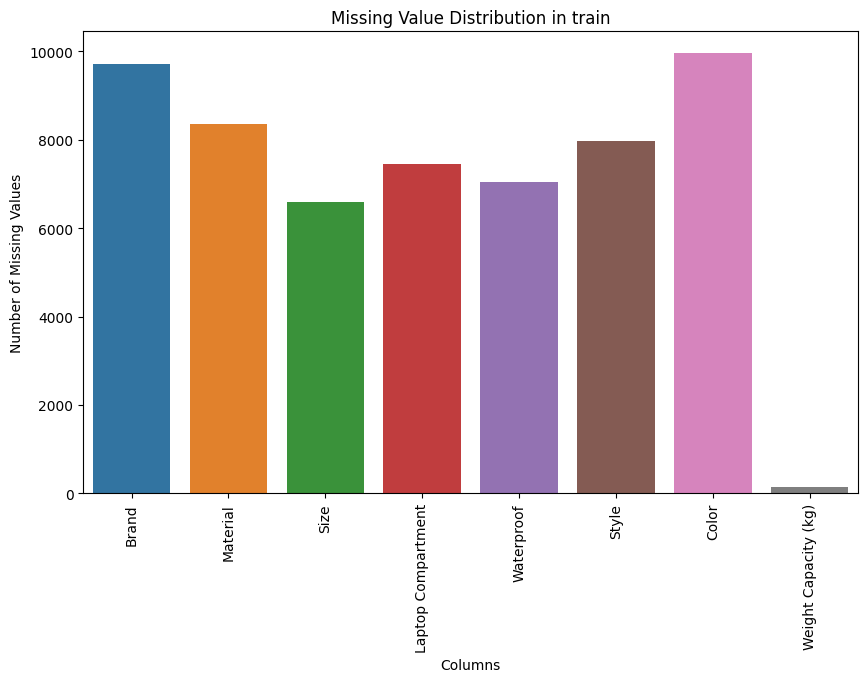

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

missing_data = train.isnull().sum()
missing_data = missing_data[missing_data > 0] # do not show missing data if there is no 
if not missing_data.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_data.index, y=missing_data.values)
    plt.title('Missing Value Distribution in train')
    plt.xlabel('Columns')
    plt.ylabel('Number of Missing Values')
    plt.xticks(rotation=90)
    plt.show()
else:
    print("No missing values in the dataset.")

In [5]:
# Trouver les colonnes communes (sans A, J et K)
common_columns = list(set(train.columns) & set(test.columns))  # Intersection des colonnes
print(common_columns)
columns_to_exclude = ["Weight Capacity (kg)", "id"]  # Mets ici les bons noms
columns_to_compare = [col for col in common_columns if col not in columns_to_exclude]
print(columns_to_compare)

# Vérifier qu'on a bien des colonnes à comparer
if not columns_to_compare:
    print("Aucune colonne commune pour comparer les fichiers après exclusion de A, J et K.")
else:
    # Fusionner pour voir les correspondances
    merged = test.merge(train, on=columns_to_compare, how='left', indicator=True)

    # Séparer les lignes identiques et celles absentes
    identical_rows = merged[merged['_merge'] == 'both'].drop(columns=['_merge'])
    not_in_train = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])

    # Afficher les résultats
    if not identical_rows.empty:
        print("Lignes de test qui sont présentes dans train (hors colonnes A, J et K) :")
        print(identical_rows)
    else:
        print("Aucune ligne de test ne correspond exactement à une ligne de train (hors A, J et K).")

    if not not_in_train.empty:
        print("\nLignes de test qui ne sont PAS dans train (hors colonnes A, J et K) :")
        print(not_in_train)
    else:
        print("\nToutes les lignes de test sont présentes dans train (hors colonnes A, J et K).")

['Compartments', 'Size', 'Style', 'Waterproof', 'Material', 'Brand', 'id', 'Color', 'Laptop Compartment', 'Weight Capacity (kg)']
['Compartments', 'Size', 'Style', 'Waterproof', 'Material', 'Brand', 'Color', 'Laptop Compartment']
Lignes de test qui sont présentes dans train (hors colonnes A, J et K) :
          id_x         Brand Material    Size  Compartments  \
0       300000          Puma  Leather   Small           2.0   
1       300000          Puma  Leather   Small           2.0   
2       300000          Puma  Leather   Small           2.0   
3       300000          Puma  Leather   Small           2.0   
4       300001          Nike   Canvas  Medium           7.0   
...        ...           ...      ...     ...           ...   
991941  499999  Under Armour  Leather  Medium           8.0   
991942  499999  Under Armour  Leather  Medium           8.0   
991943  499999  Under Armour  Leather  Medium           8.0   
991944  499999  Under Armour  Leather  Medium           8.0   
9919

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


# **Since there are missing data let's flag**

In [6]:
cat_cols = ["Brand", "Material", "Size", "Laptop Compartment", "Waterproof", "Style", "Color", "Weight Capacity (kg)"]

for col in cat_cols:
    print(col," before : ", train[col].dtype)
    if col == "Weight Capacity (kg)":
        train[col] = train[col].fillna(0).astype(float)
        test[col] = test[col].fillna(0).astype(float)
    else:
        train[col] = train[col].fillna('Unknown').astype('category')
        test[col] = test[col].fillna('Unknown').astype('category')
    print(col, " after : ", train[col].dtype)

missing_data = train.isnull().sum()

missing_data = missing_data[missing_data > 0] # do not show missing data if there is no 
if not missing_data.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_data.index, y=missing_data.values)
    plt.title('Missing Value Distribution in train')
    plt.xlabel('Columns')
    plt.ylabel('Number of Missing Values')
    plt.xticks(rotation=90)
    plt.show()
else:
    print("No missing values in the dataset.")


Brand  before :  object
Brand  after :  category
Material  before :  object
Material  after :  category
Size  before :  object
Size  after :  category
Laptop Compartment  before :  object
Laptop Compartment  after :  category
Waterproof  before :  object
Waterproof  after :  category
Style  before :  object
Style  after :  category
Color  before :  object
Color  after :  category
Weight Capacity (kg)  before :  float64
Weight Capacity (kg)  after :  float64
No missing values in the dataset.


# **Data analysis** 

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


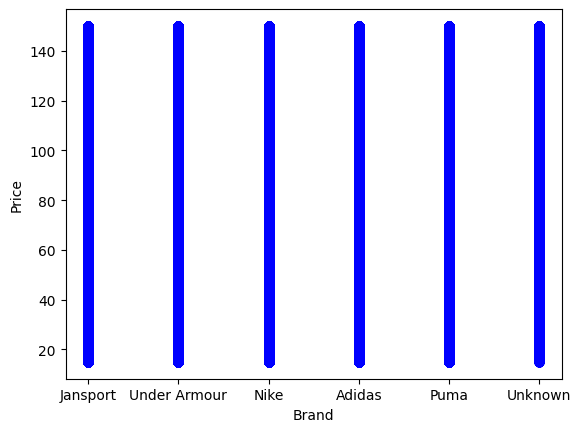

In [7]:
# let's plot each of the features against the price, to see how linear their relationship is:
plt.scatter(train["Brand"], train["Price"],  color='blue')
plt.xlabel("Brand")
plt.ylabel("Price")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

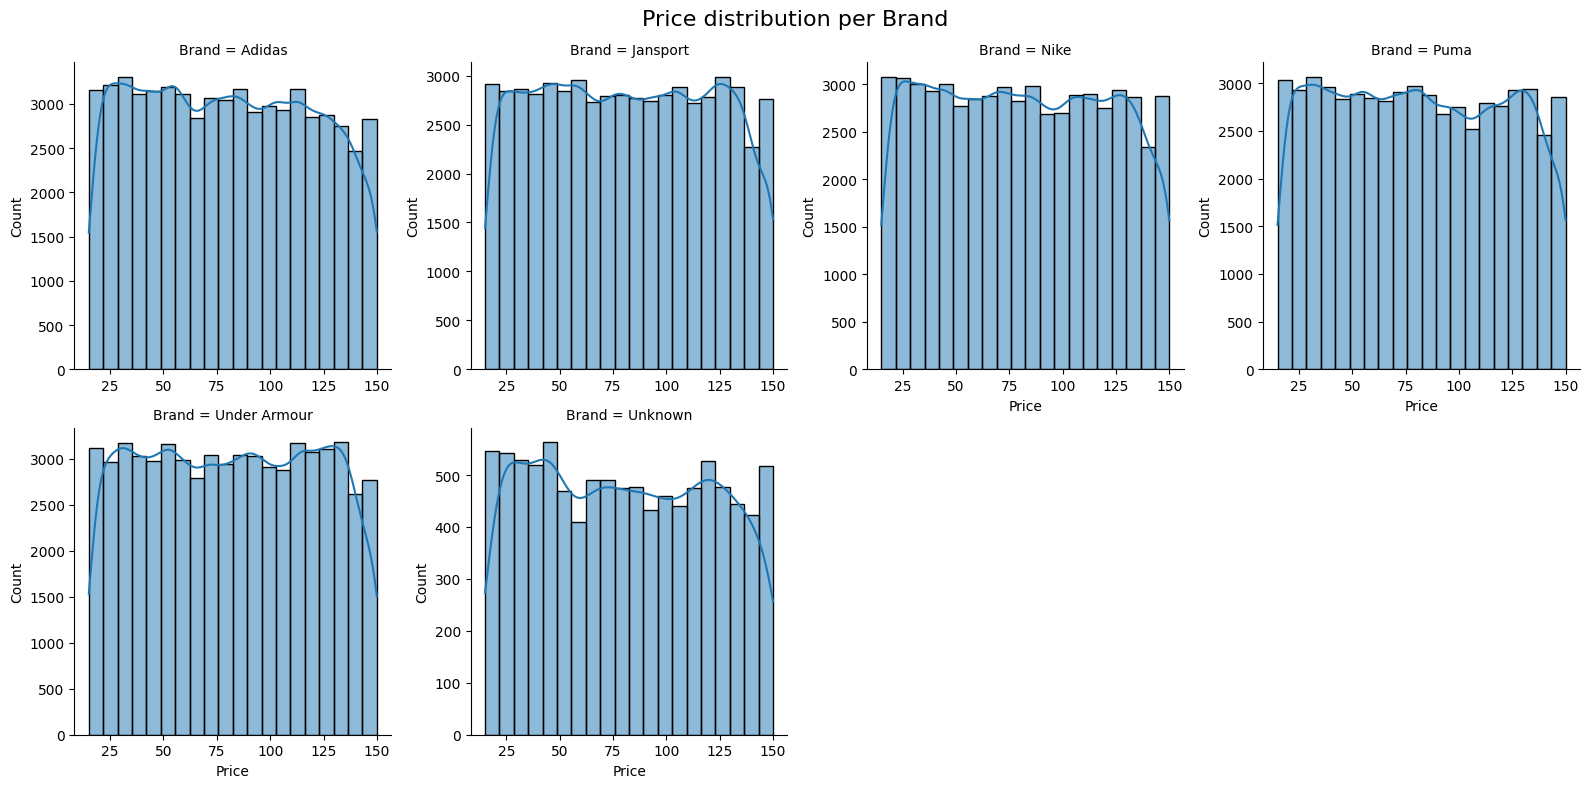

In [8]:
# Définir la grille avec un histogramme par marque
g = sns.FacetGrid(train, col="Brand", col_wrap=4, height=4, sharex=False, sharey=False)
g.map(sns.histplot, "Price", bins=20, kde=True)

# Ajuster l'affichage
g.fig.suptitle("Price distribution per Brand", fontsize=16)
plt.tight_layout()
plt.show()

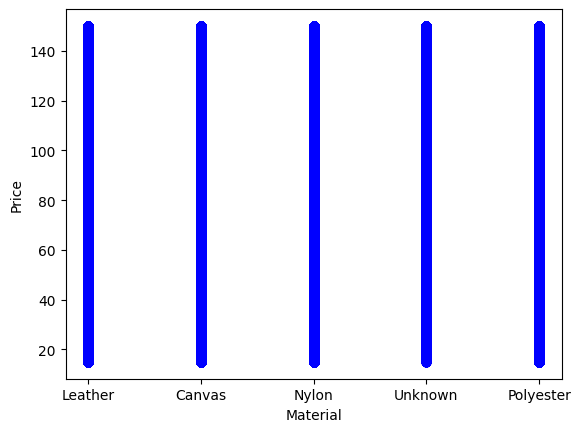

In [9]:
# let's plot each of the features against the price, to see how linear their relationship is:
plt.scatter(train["Material"], train["Price"],  color='blue')
plt.xlabel("Material")
plt.ylabel("Price")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

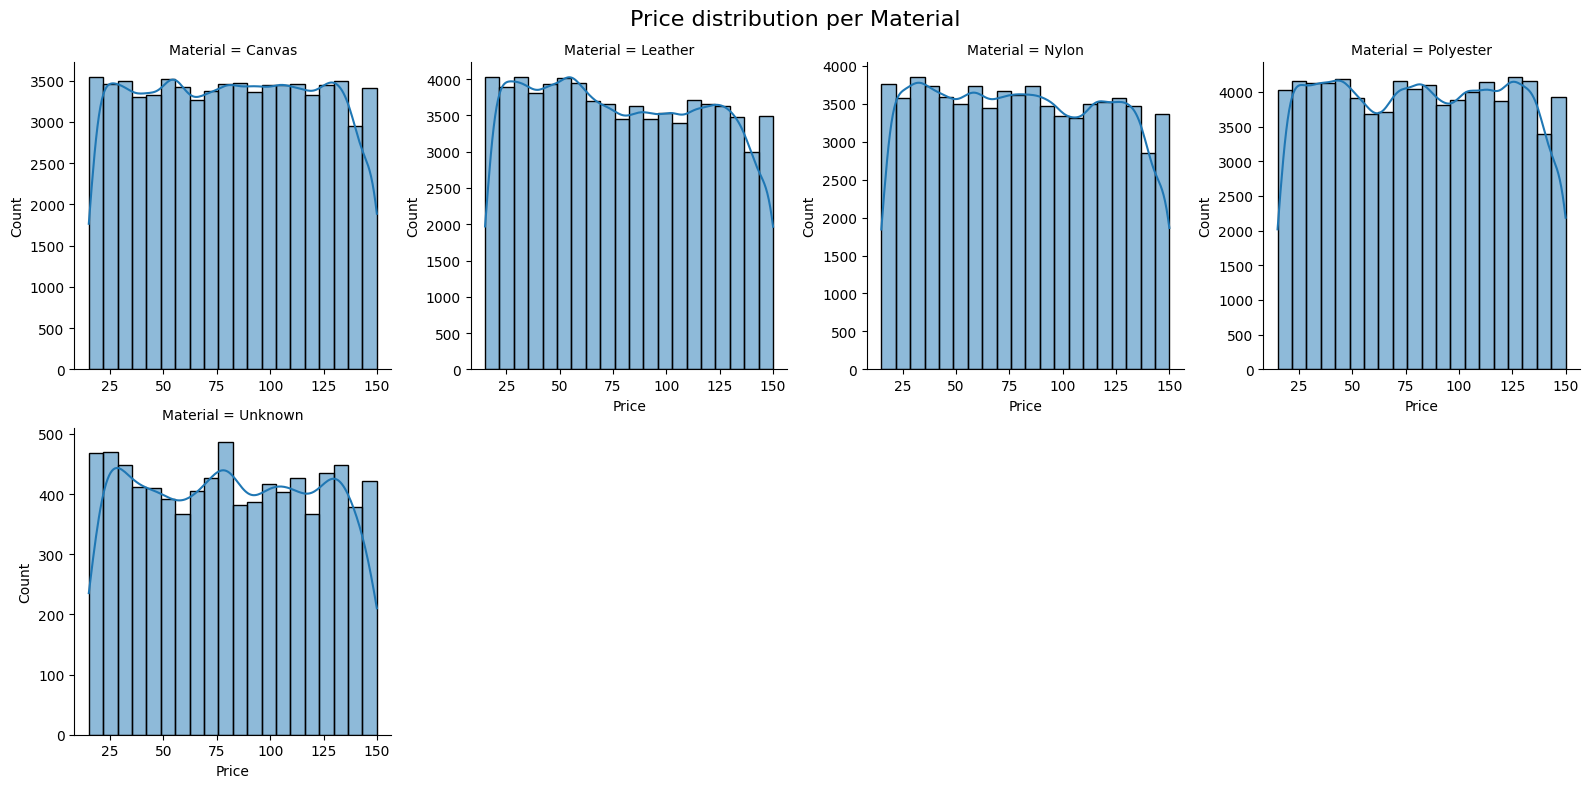

In [10]:
# Définir la grille avec un histogramme par material
g = sns.FacetGrid(train, col="Material", col_wrap=4, height=4, sharex=False, sharey=False)
g.map(sns.histplot, "Price", bins=20, kde=True)

# Ajuster l'affichage
g.fig.suptitle("Price distribution per Material", fontsize=16)
plt.tight_layout()
plt.show()

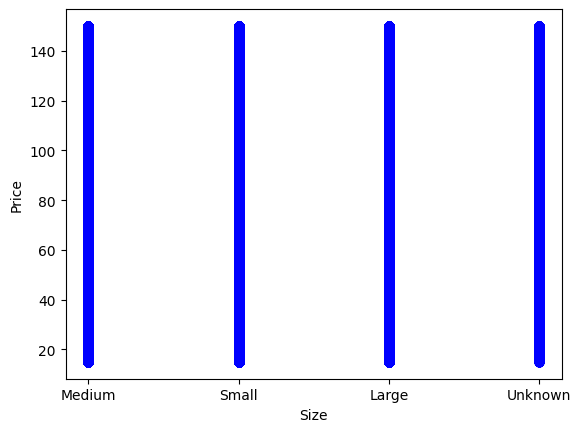

In [12]:
# let's plot each of the features against the price, to see how linear their relationship is:
plt.scatter(train["Size"], train["Price"],  color='blue')
plt.xlabel("Size")
plt.ylabel("Price")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

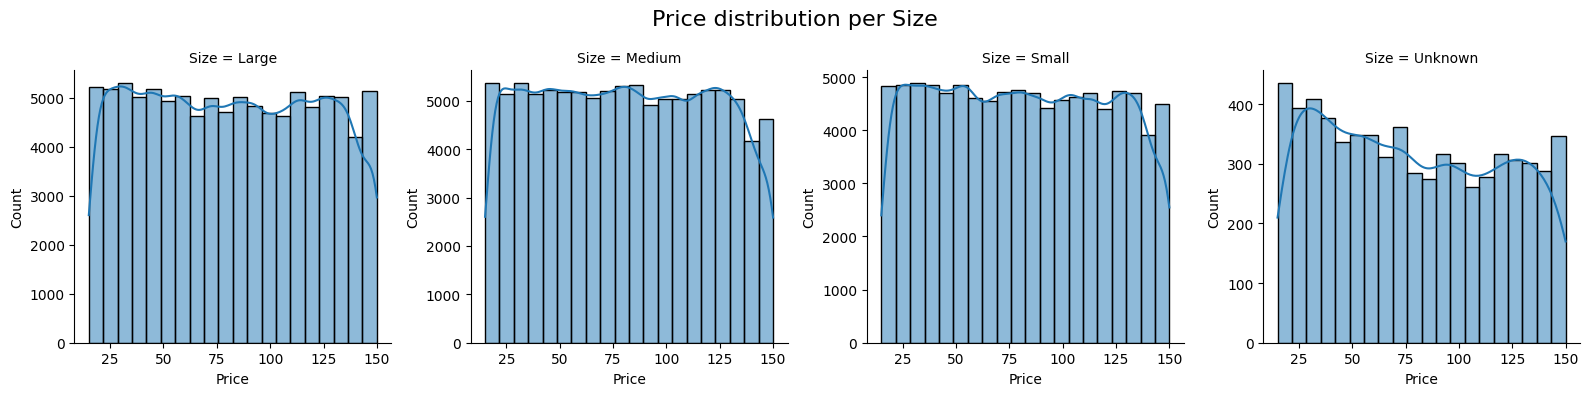

In [11]:
# Définir la grille avec un histogramme par Size
g = sns.FacetGrid(train, col="Size", col_wrap=4, height=4, sharex=False, sharey=False)
g.map(sns.histplot, "Price", bins=20, kde=True)

# Ajuster l'affichage
g.fig.suptitle("Price distribution per Size", fontsize=16)
plt.tight_layout()
plt.show()

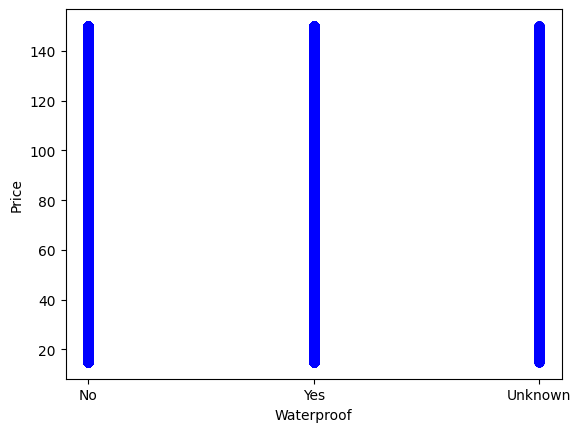

In [13]:
# let's plot each of the features against the price, to see how linear their relationship is:
plt.scatter(train["Waterproof"], train["Price"],  color='blue')
plt.xlabel("Waterproof")
plt.ylabel("Price")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


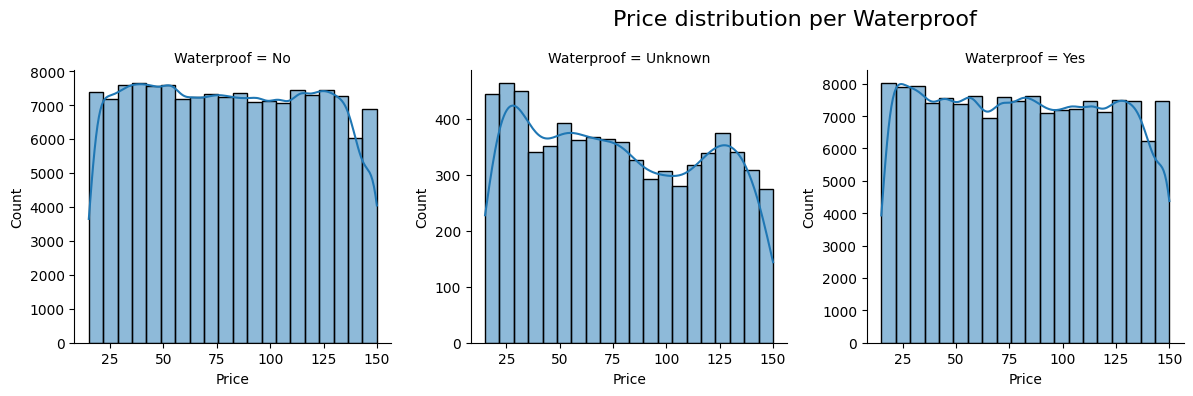

In [14]:
# Définir la grille avec un histogramme par Waterproof
g = sns.FacetGrid(train, col="Waterproof", col_wrap=4, height=4, sharex=False, sharey=False)
g.map(sns.histplot, "Price", bins=20, kde=True)

# Ajuster l'affichage
g.fig.suptitle("Price distribution per Waterproof", fontsize=16)
plt.tight_layout()
plt.show()

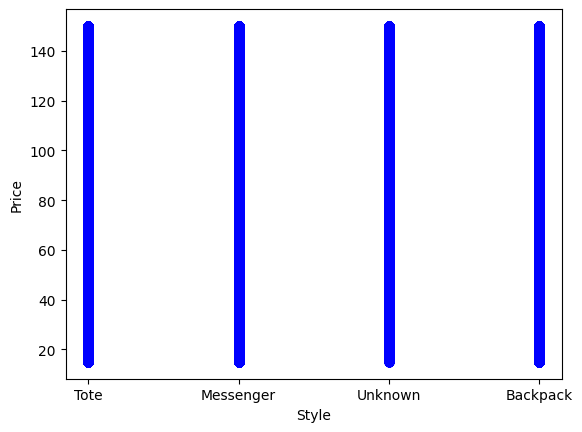

In [15]:
# let's plot each of the features against the price, to see how linear their relationship is:
plt.scatter(train["Style"], train["Price"],  color='blue')
plt.xlabel("Style")
plt.ylabel("Price")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

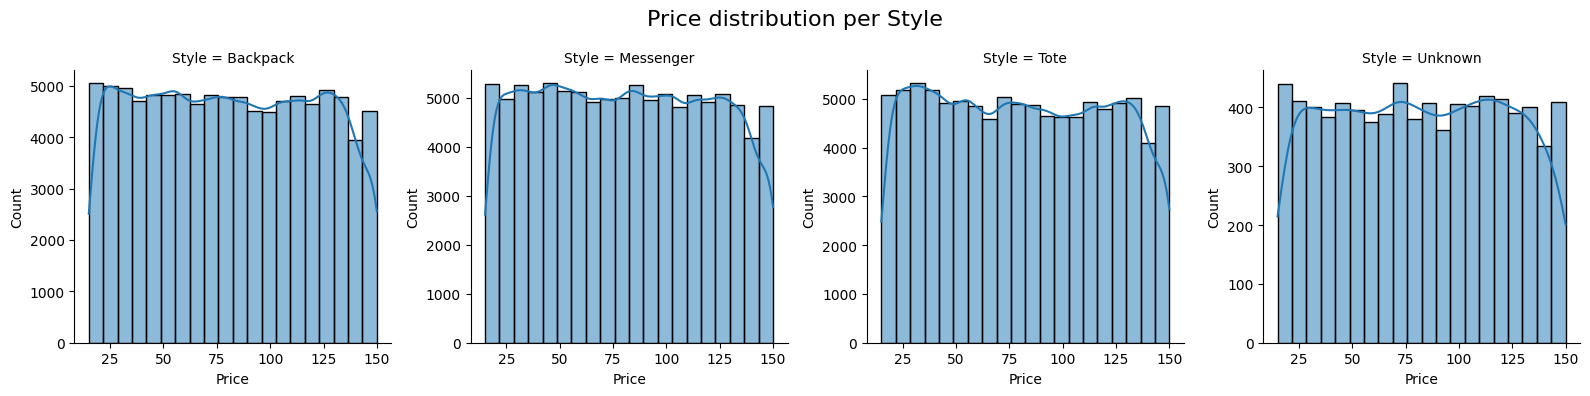

In [16]:
# Définir la grille avec un histogramme par Waterproof
g = sns.FacetGrid(train, col="Style", col_wrap=4, height=4, sharex=False, sharey=False)
g.map(sns.histplot, "Price", bins=20, kde=True)

# Ajuster l'affichage
g.fig.suptitle("Price distribution per Style", fontsize=16)
plt.tight_layout()
plt.show()

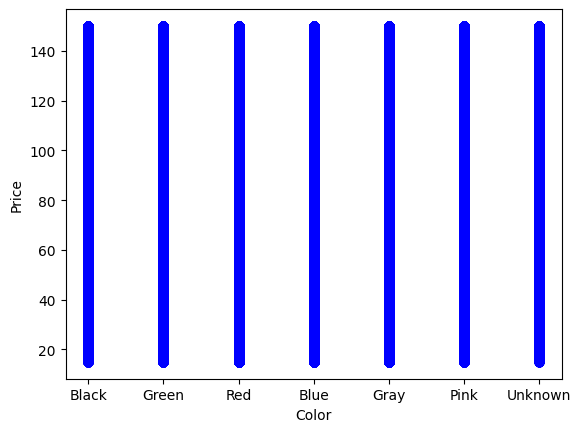

In [17]:
# let's plot each of the features against the price, to see how linear their relationship is:
plt.scatter(train["Color"], train["Price"],  color='blue')
plt.xlabel("Color")
plt.ylabel("Price")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

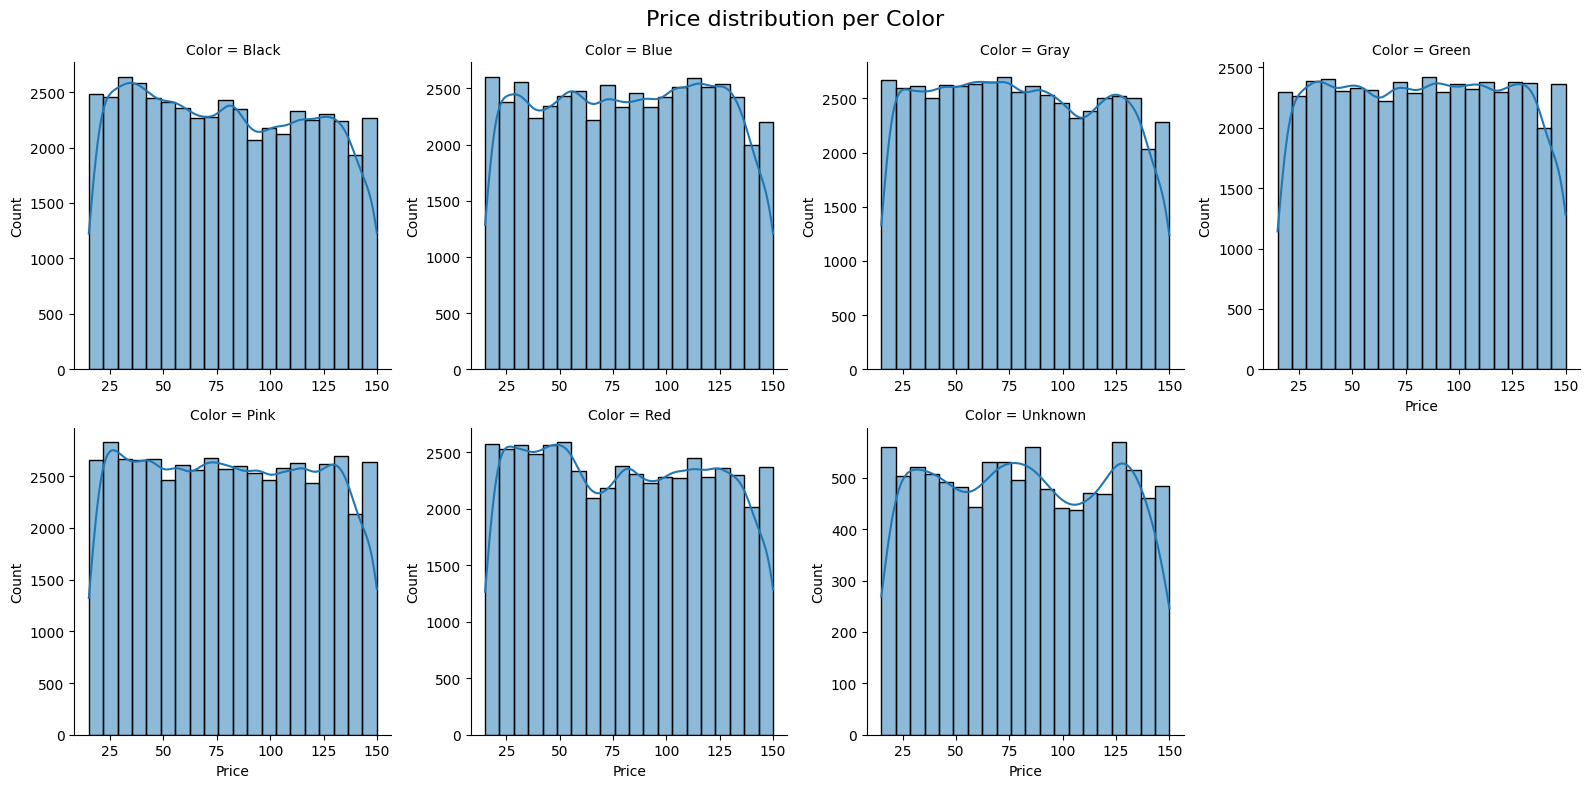

In [18]:
# Définir la grille avec un histogramme par Waterproof
g = sns.FacetGrid(train, col="Color", col_wrap=4, height=4, sharex=False, sharey=False)
g.map(sns.histplot, "Price", bins=20, kde=True)

# Ajuster l'affichage
g.fig.suptitle("Price distribution per Color", fontsize=16)
plt.tight_layout()
plt.show()

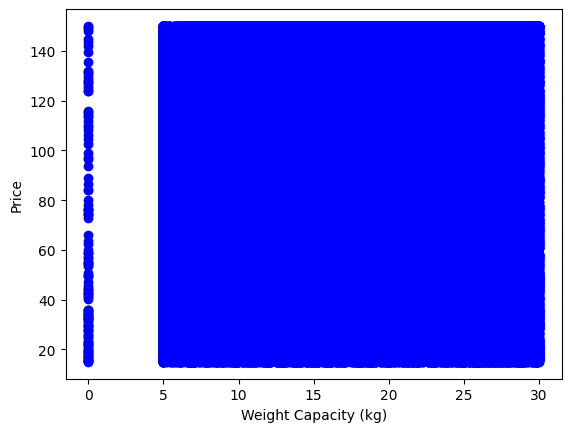

In [19]:
# let's plot each of the features against the price, to see how linear their relationship is:
plt.scatter(train["Weight Capacity (kg)"], train["Price"],  color='blue')
plt.xlabel("Weight Capacity (kg)")
plt.ylabel("Price")
plt.show()

<ipython-input-20-e942da6c4b03>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Price Range'] = pd.cut(subset['Price'], bins=price_bins, labels=price_labels, right=False)


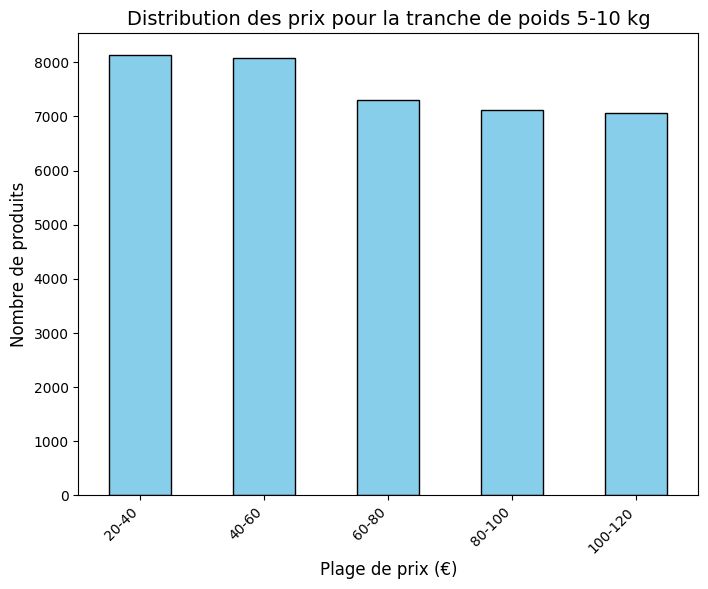

<ipython-input-20-e942da6c4b03>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Price Range'] = pd.cut(subset['Price'], bins=price_bins, labels=price_labels, right=False)


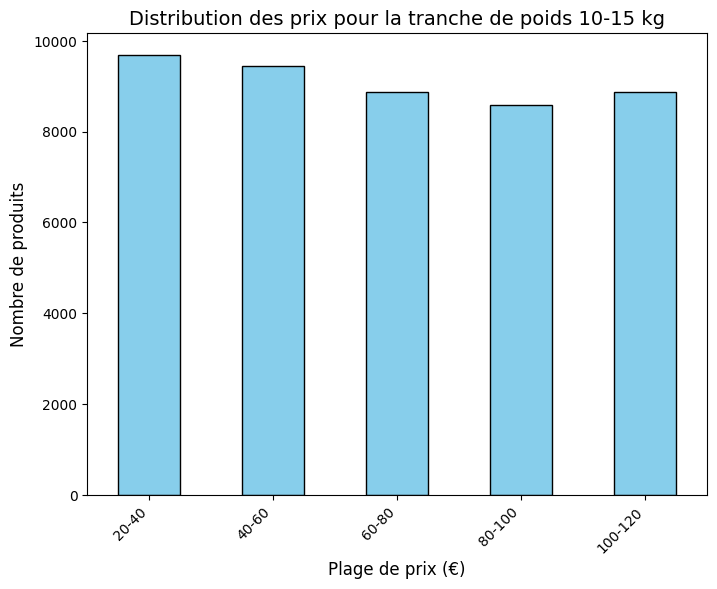

<ipython-input-20-e942da6c4b03>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Price Range'] = pd.cut(subset['Price'], bins=price_bins, labels=price_labels, right=False)


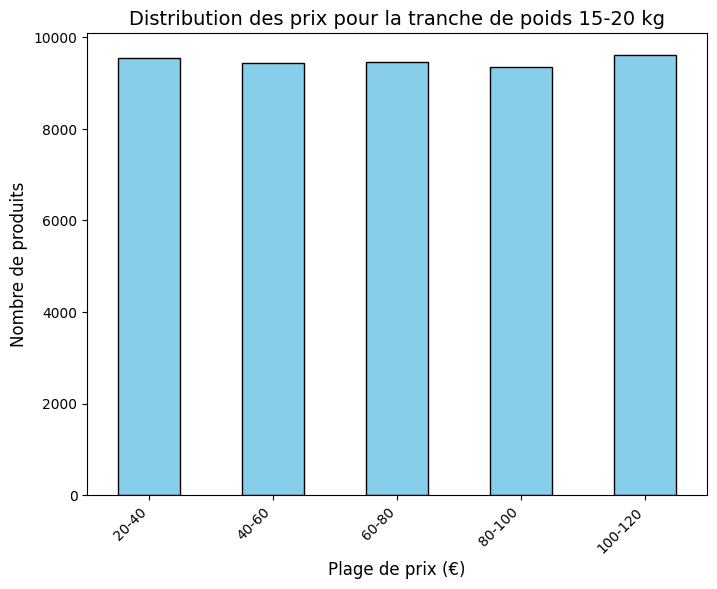

<ipython-input-20-e942da6c4b03>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Price Range'] = pd.cut(subset['Price'], bins=price_bins, labels=price_labels, right=False)


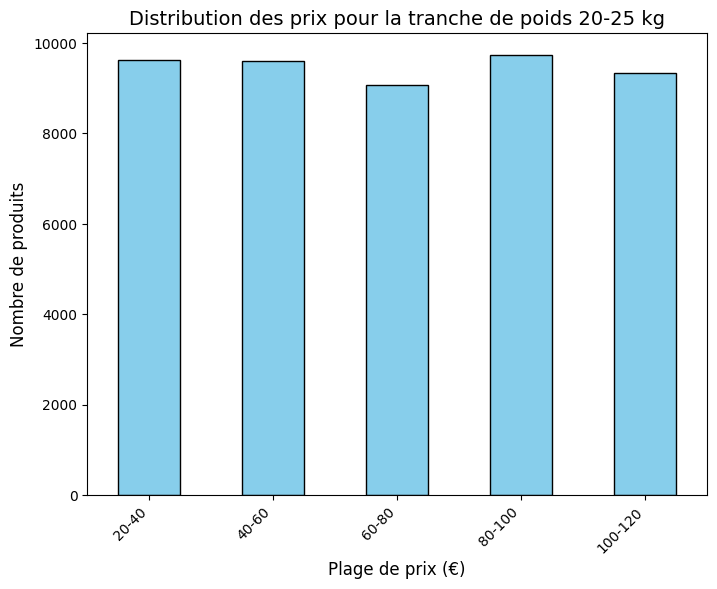

<ipython-input-20-e942da6c4b03>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Price Range'] = pd.cut(subset['Price'], bins=price_bins, labels=price_labels, right=False)


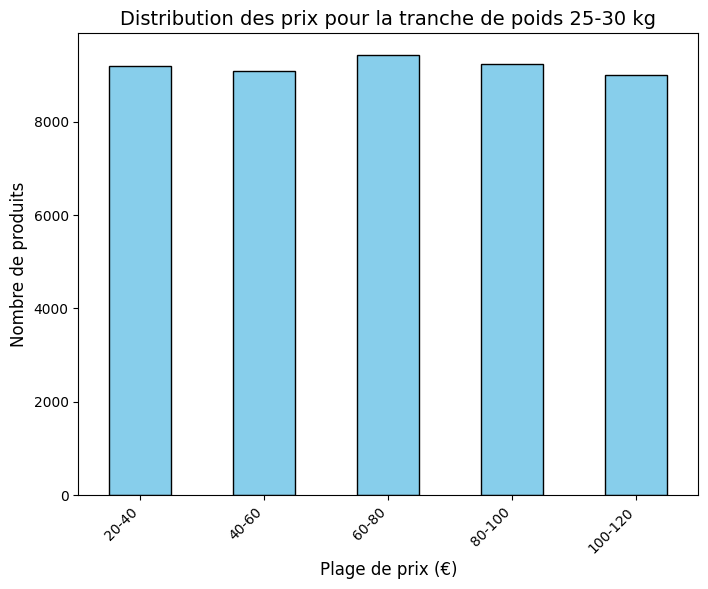

In [20]:
# Définir les intervalles de poids
weight_bins = [5, 10, 15, 20, 25, 30]
weight_labels = ['5-10 kg', '10-15 kg', '15-20 kg', '20-25 kg', '25-30 kg']

# Créer une nouvelle colonne 'Weight Range'
train['Weight Range'] = pd.cut(train['Weight Capacity (kg)'], bins=weight_bins, labels=weight_labels, right=False)

# Définir les intervalles de prix
price_bins = [20, 40, 60, 80, 100, 120]
price_labels = ['20-40', '40-60', '60-80', '80-100', '100-120']

# Créer une fonction pour obtenir la distribution des prix pour chaque tranche de poids
def plot_price_distribution_for_weight_range(weight_range):
    subset = train[train['Weight Range'] == weight_range]
    subset['Price Range'] = pd.cut(subset['Price'], bins=price_bins, labels=price_labels, right=False)
    
    price_distribution = subset['Price Range'].value_counts().sort_index()
    
    # Afficher la distribution sous forme de bar chart
    plt.figure(figsize=(8, 6))
    price_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Distribution des prix pour la tranche de poids {weight_range}', fontsize=14)
    plt.xlabel('Plage de prix (€)', fontsize=12)
    plt.ylabel('Nombre de produits', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Afficher les distributions pour chaque tranche de poids
for weight_range in weight_labels:
    plot_price_distribution_for_weight_range(weight_range)



It seems that price is really random ! no correlation between categories and price!

# **Let's compute the average value**

In [12]:
# Calculer la moyenne de la colonne 'price'
mean_price = train["Price"].mean()

print(f"Valeur moyenne de 'price' : {mean_price}")

import csv

# Nom du fichier CSV
filename = "output.csv"

# Création et écriture des données
with open(filename, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)

    # Écriture de l'en-tête
    writer.writerow(["id", "Price"])

    # Écriture des 200000 lignes suivantes
    for i in range(0, 200000):
        writer.writerow([i + 300000, mean_price])

print(f"Fichier '{filename}' créé avec succès.")

Valeur moyenne de 'price' : 81.35820101189991
Fichier 'output.csv' créé avec succès.


# **Let's try various Regression schemes**

starting with very basic regression

In [ ]:
y = train['Price'] 
train = train.drop(['Price'],axis=1)
X = train
X_test = test